In [1]:
from commonfunctions import *
import numpy as np
import cv2
import math
import timeit
from multiprocessing import Process
%matplotlib inline
%load_ext autoreload
%autoreload 2

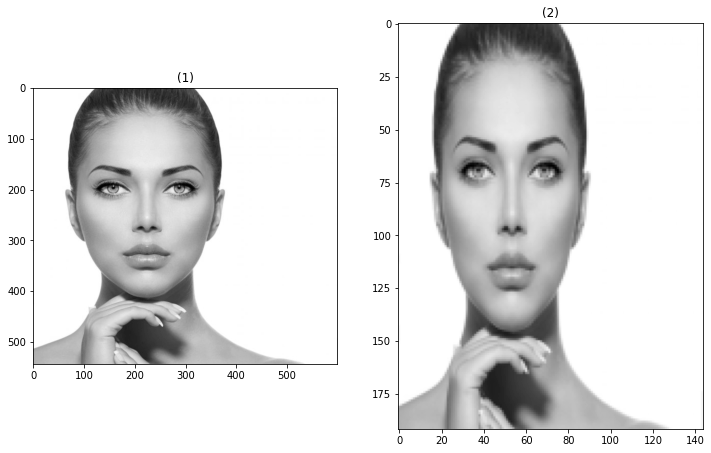

In [2]:
img = rgb2gray(io.imread('test_images\woman.jpg'))

resized = cv2.resize(img, (144,192), interpolation = cv2.INTER_AREA)
show_images([img,resized])

In [2]:
def HOG_descriptor(img):
    resized = cv2.resize(img, (48,64), interpolation = cv2.INTER_AREA)
    mag,angle=gradient(resized)
#     print(resized.shape)
    
    #loop on mag and angle to get 16*16 cell
    windowsize_r =16
    windowsize_c =16
    bin_size=20
    mag_cells=[]
    ang_cells=[]

    
    #check code image on what`s app for efficient split
    
    #TODO make 2d
    
#     for r in range(0,mag.shape[0] - windowsize_r, windowsize_r):
#         temp_mag=[]
#         temp_angle=[]
#         for c in range(0,mag.shape[1] - windowsize_c, windowsize_c):  
            
#             temp_mag.append(mag[r:r+windowsize_r,c:c+windowsize_c])
#             temp_angle.append(angle[r:r+windowsize_r,c:c+windowsize_c])
        
#         mag_cells.append(temp_mag)
#         ang_cells.append(temp_angle)  

    #get 16*16 cells
    
    start = timeit.default_timer()
    mag_cells=cut_image(mag,windowsize_r,windowsize_c)
    ang_cells=cut_image(angle,windowsize_r,windowsize_c)
    #print((mag_cells.shape[0],mag_cells.shape[1],-1))
    #mag_cells=np.resize(mag_cells,(mag_cells.shape[0],mag_cells.shape[1],-1))
    #ang_cells=np.resize(ang_cells,(mag_cells.shape[0],mag_cells.shape[1],-1))
    #mag_ang_cells=np.concatenate([mag_cells, ang_cells],axis=-1)
    #print(mag_ang_cells.shape)
    #stop = timeit.default_timer()
    #print("cutting",stop-start)
    
#     print(mag_cells.shape)
#     show_images([mag_cells[1][0],mag_cells[1][1],mag_cells[1][2],mag_cells[1][3]])
    
    #histogram of each cell
    hist=np.zeros((mag_cells.shape[0], mag_cells.shape[1],180//bin_size))
    #start = timeit.default_timer()
    #print(mag_cells.shape)
    start = timeit.default_timer()
    for r in range(mag_cells.shape[0]):
        for  c in range(mag_cells.shape[1]):
            hist[r][c]=HOG_histogram(mag_cells[r][c],ang_cells[r][c], bin_size)
    stop = timeit.default_timer()
    #print("hist",stop-start)
    #start = timeit.default_timer()
    #hist=np.apply_along_axis(HOG_histogram, -1, mag_ang_cells)
    #stop = timeit.default_timer()
    #print(stop-start)
    
    
    start = timeit.default_timer()
    norm_hist=[]
    for r in range(hist.shape[0]-1):
        for  c in range(hist.shape[1]-1):
            temp=hist[r:r+2, c:c+2].reshape(-1)
            temp/=np.linalg.norm(temp)
            norm_hist+=list(temp)
    norm_hist=np.asarray(norm_hist) 
    stop = timeit.default_timer()
    #print("averaging",stop-start)
#     print('size of hist',hist.shape)
#     print('size of norm_hist',norm_hist.shape)
#     print(hist)
    return norm_hist
   
    
 
    

In [3]:
def cut_image(img,windowsize_r,windowsize_c):
    tiles=[]
    img_r=img.shape[0]
    img_c=img.shape[1]
    tiles=img.reshape(img_r//windowsize_r,
                      windowsize_r,
                     img_c//windowsize_c,
                     windowsize_c)
    tiles=tiles.swapaxes(1,2)
    return tiles

In [4]:
def HOG_histogram(mag,angle,bin_size=20):
    start = timeit.default_timer()
    #mag=mag_angle[:mag_angle.shape[0]//2]
    #angle=mag_angle[mag_angle.shape[0]//2:]
    hist=np.zeros(int(180/bin_size))
    low_bins=20*(angle//20)
    
    high_bins=20+low_bins
    
    ## weights
    weight_low_bin=(abs(high_bins-angle)/20)*mag
    weight_high_bin=(abs(angle-low_bins)/20)*mag
    
    
    high_bins=high_bins%180
    for i in range(hist.shape[0]):
        
        votes_low=np.sum(weight_low_bin[(low_bins//20)==i])
        votes_high=np.sum(weight_high_bin[(high_bins//20)==i])
        hist[i]=votes_low+votes_high
    stop = timeit.default_timer()
    #print(stop-start)
    return hist 
#     print(np.sum(mag))

#     print(np.sum(hist))

    
    
    

In [5]:
#cell is a matrix 8x8
def gradient(img):
    img=np.float32(img) / 255.0
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

#     show_images([gx,gy,mag,angle],["gx","gy","mag","angle"])
#     print("mag",np.sum(mag))
    return mag,angle%180

    
    

In [90]:
from skimage import data, color, feature,transform
start = timeit.default_timer()
print(HOG_descriptor(img))
stop = timeit.default_timer()
print(stop-start)
start = timeit.default_timer()
print(feature.hog(cv2.resize(img, (48,64), interpolation = cv2.INTER_AREA),cells_per_block=(2,2),pixels_per_cell=(16, 16)).shape)
end = timeit.default_timer()
print(end-start)

(4, 3, -1)
0.0005584999998973217
0.0005428999998002837
0.0009826000000430213
0.0004809000001841923
0.0007950999997774488
0.0004984000001968525
0.0004582999999911408
0.00046380000003409805
0.0004453999999896041
0.00045799999998052954
0.0004687000000558328
0.00043559999994613463
0.00978239999994912
[3.80960304e-01 3.36877402e-01 1.69861268e-01 6.74182848e-02
 5.08981425e-02 7.60795533e-03 0.00000000e+00 3.65233305e-04
 9.48805627e-03 3.40926204e-01 1.04242470e-02 2.44595594e-03
 5.43743491e-03 3.78325272e-02 9.02577644e-02 1.09503373e-01
 1.55070722e-01 3.43230957e-01 3.24132304e-01 1.32203511e-01
 4.56204484e-02 3.91851057e-02 6.59141864e-02 1.07690438e-01
 8.52455344e-02 6.51637762e-02 2.08821876e-01 3.44359334e-01
 2.19761920e-01 6.86211079e-02 1.04378843e-01 1.01770842e-01
 7.85796030e-02 5.68762651e-02 5.29247255e-02 1.52249137e-01
 4.78312982e-01 1.46250203e-02 3.43162968e-03 7.62861778e-03
 5.30783163e-02 1.26629927e-01 1.53631150e-01 2.17561274e-01
 4.81546505e-01 1.78069066e-03 

In [154]:
from sklearn.datasets import fetch_lfw_people
from skimage import data, color, feature,transform
from  sklearn.feature_extraction.image import PatchExtractor

faces = fetch_lfw_people()

In [155]:
# SVM

#positive data
positive_patches = faces.images
print(positive_patches.shape)


imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]


(13233, 62, 47)


<ipython-input-155-00e0f3567f46>:11: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


In [156]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

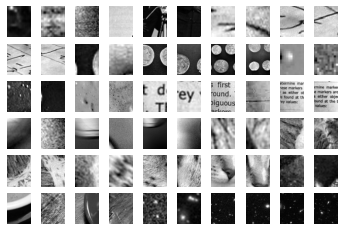

In [157]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [158]:
from itertools import chain
X_train = np.array([HOG_descriptor(im)
                    for im in chain(positive_patches, negative_patches)])

# add labels
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)
(4, 3, 9)


In [159]:
y_train = np.zeros(X_train2.shape[0])
y_train[:positive_patches.shape[0]] = 1

NameError: name 'X_train2' is not defined

In [22]:
from itertools import chain
X_train2 = np.array([feature.hog(cv2.resize(im, (48,64), interpolation = cv2.INTER_AREA),cells_per_block=(2,2),pixels_per_cell=(16, 16))
                    for im in chain(positive_patches, negative_patches)])

# # add labels
# y_train2 = np.zeros(X_train2.shape[0])
# y_train[:positive_patches.shape[0]] = 1

In [25]:
#print(X_train.shape)
print(X_train2.shape)
#print(X_train[0])
print(HOG_descriptor(positive_patches[0]))

(43233, 216)
[0.35228668 0.36792583 0.2215744  0.10520636 0.09203483 0.10656079
 0.07036886 0.02265676 0.03643044 0.03225074 0.03138212 0.08891959
 0.08115815 0.07832351 0.10688566 0.14841909 0.05918661 0.02550261
 0.38653894 0.25374788 0.11809531 0.16447649 0.26158844 0.15827211
 0.03572182 0.05232537 0.19912394 0.22500954 0.20211311 0.09604017
 0.04397855 0.06550356 0.03666318 0.07744436 0.12559385 0.26739236
 0.03504756 0.03410362 0.09663081 0.08819629 0.08511583 0.11615493
 0.16129018 0.06431935 0.02771422 0.24492377 0.06634386 0.05744448
 0.10185001 0.0630927  0.03006361 0.06323451 0.23409797 0.45689422
 0.24452266 0.21964062 0.1043689  0.04779243 0.07118412 0.03984266
 0.08416043 0.13648551 0.29058097 0.39168258 0.13326623 0.05407262
 0.08461041 0.21047498 0.1629128  0.17408    0.13370654 0.20010876
 0.31594762 0.20740741 0.09652826 0.13443912 0.21381609 0.12936781
 0.02919816 0.0427695  0.16275911 0.18391738 0.16520239 0.07850092
 0.03594701 0.05354104 0.0299676  0.06330115 0.10

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection  import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

print('gaussian',cross_val_score(GaussianNB(), X_train2, y_train))

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train2, y_train)
print('svm',grid.best_score_)

gaussian [0.97397941 0.97710189 0.95917659 0.98207263 0.98033773]


C:\Users\Aya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Aya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Aya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Aya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Aya\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnin

svm 0.9896839170700202


In [3]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(grid, filename)

NameError: name 'grid' is not defined

In [4]:
grid.predict(io.imread('test_images\woman.jpg')

SyntaxError: unexpected EOF while parsing (<ipython-input-4-14e350976de5>, line 1)

In [199]:
import joblib
filename = 'model_cv.sav'
loaded_model = joblib.load(filename)
from skimage import data, color, feature,transform
x=loaded_model.predict(feature.hog(cv2.resize(io.imread('test_images\woman.jpg'), (48,64), interpolation = cv2.INTER_AREA),cells_per_block=(2,2),pixels_per_cell=(16, 16)).reshape(1,-1))
print(x)

ValueError: X has 216 features per sample; expecting 144

In [36]:
def hog_process():
    print("meeen")
    #prediction=loaded_model.predict(feature.hog(img))
    #print(prediction)
    #if prediction!=0:
    #    lst.append((l,w,row,col))
    

In [41]:
def search_for_face2(img,division_factor1,division_factor2,step):
    x,y=img.shape
    l,w=(int(img.shape[0]/division_factor1),int(img.shape[1]/division_factor2))
    print("mememem")
    processes=[]
    predictions=[]
    for row in range(0,x-l,step):
        for col in range(0,y-w,step):
            #print(l,w)
            #print("hehhh")
            partition=img[row:row+l,col:col+w]
            #show_images([partition])
            #, args=(cv2.resize(partition, (48,64), interpolation = cv2.INTER_AREA),predictions,l,w,row,col,)
            processes.append(Process(target=hog_process))
    #print(processes)
    for process in processes:
        process.start()
    for process in processes:
        process.join()


In [42]:
search_for_face2(cv2.resize(rgb2gray(io.imread('test_images\woman.jpg')), (150,150), interpolation = cv2.INTER_AREA),1.3,1.7,5)

mememem


In [187]:
import cv2
winSize = (64,64)
blockSize = (32,32)
blockStride = (32,32)
cellSize = (16,16)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [175]:
from itertools import chain
X_train2 = np.array([hog.compute(img=cv2.resize(im, (64,64), interpolation = cv2.INTER_AREA).astype('uint8'),winStride=(64,64))
                    for im in chain(positive_patches, negative_patches)])
X_train2=np.squeeze(X_train2, axis=2)


In [176]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection  import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

print('gaussian',cross_val_score(GaussianNB(), X_train2, y_train))

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train2, y_train)
print('svm',grid.best_score_)

gaussian [0.58586793 0.78154273 0.80536602 0.98033773 0.97860282]
svm 0.9669012833023295


In [177]:
import joblib
filename = 'model_cv.sav'
joblib.dump(grid, filename)

['model_cv.sav']

In [161]:
print(positive_patches.shape)

(13233, 62, 47)


In [336]:
def search_for_face_cv(img,scale,win_stride=(16,16)):
    new_image=cv2.resize(img, (64*scale,64*scale), interpolation = cv2.INTER_AREA)
    start = timeit.default_timer()
    hog_feature=np.array(list(hog.compute(new_image.astype('uint8'),winStride=win_stride)))
    hog_feature=hog_feature.reshape(-1,144)
    prediction=loaded_model.predict(hog_feature)
    prediction=prediction.reshape(int(math.sqrt(len(prediction))),int(math.sqrt(len(prediction))))
    index=np.array(list(np.where(prediction==1)))
    print(index.shape)
    print(prediction)
    for i in range(index.shape[1]):
        print("leeeeeh",index[:,i])
        y=index[:,i]
        i=y[0]*win_stride[0]
        j=y[1]*win_stride[1]
        show_images([new_image[i:i+64,j:j+64]])
            
#         i=i*64
#         j=j*64
#         print("shape",img[i:i+64,j:j+64].shape)
    
    print(prediction.shape)
    print(hog_feature.shape)
    stop = timeit.default_timer()
    print(stop-start)

In [337]:
def search_for_face(img,division_factor1,division_factor2,step):
    x,y=img.shape
    l,w=(int(img.shape[0]/division_factor1),int(img.shape[1]/division_factor2))
    start = timeit.default_timer()
    for row in range(0,x-l,step):
        for col in range(0,y-w,step):
            #print(l,w)
            #print("hehhh")
            partition=img[row:row+l,col:col+w]
            #show_images([partition])
            winStride = (16,16)
            padding = (0,0)
            locations = ((10,20),)
            print(np.array(hog.compute(img=cv2.resize(partition, (128,128), interpolation = cv2.INTER_AREA).astype('uint8'),winStride=(64,64))).shape)
            prediction=loaded_model.predict(np.array(list(hog.compute(cv2.resize(partition, (48,64), interpolation = cv2.INTER_AREA).astype('uint8')).reshape(1, -1))))
            #prediction=loaded_model.predict(feature.hog(cv2.resize(partition, (48,64), interpolation = cv2.INTER_AREA),cells_per_block=(2,2),pixels_per_cell=(16, 16)).reshape(1, -1),)
            if prediction!=0:
                print(prediction)
    stop = timeit.default_timer()
    print(stop-start)

(2, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
leeeeeh [3 0]


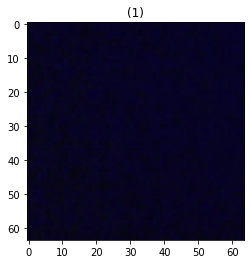

(5, 5)
(25, 144)
0.21641159999853699
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.016659299999446375
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.018561500000942033
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.007323399997403612
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.009984000000258675
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.009172899997793138
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.0086038000008557
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.007644699999218574
(2, 0)
[[0. 0

(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.008714200001122663
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.005194999997911509
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.008414100000663893
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.0068402000033529475
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.01133280000067316
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.0054751999996369705
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.006012800000462448
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0.

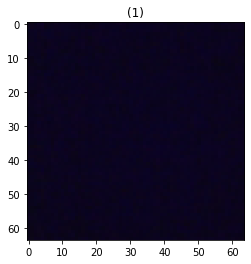

(5, 5)
(25, 144)
0.1640689999985625
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.006795999997848412
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.005117600001540268
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.006140900000900729
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.0072851000004448
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.005216500001552049
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.006918400002177805
(2, 0)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
(25, 144)
0.005055400000856025
(2, 0)
[[0. 0.

In [344]:

# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    search_for_face_cv(frame,2)
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [339]:
x=np.array([
    [1,2,3],
    [4,5,6],
    [7,8,8]
])

In [ ]:
y=np.array([
[1,2],
    [2,2]
])

In [280]:
print(y.shape)
lst1=[0]
lst2=[2]

(2, 2)


In [282]:
x[lst1]

array([[1, 2, 3]])